In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

In [2]:
def generate_real():
    real_data = torch.FloatTensor(
        [
            random.uniform(0.8, 1.0),
            random.uniform(0.0, 0.2),
            random.uniform(0.8, 1.0),
            random.uniform(0.0, 0.2),
        ]
    )
    return real_data

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(4, 3), nn.Sigmoid(), nn.Linear(3, 1), nn.Sigmoid(),
        )

        self.loss_function = nn.MSELoss()

        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)

        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        return self.model(inputs)

    def train(self, inputs, targets):
        outputs = self.forward(inputs)

        loss = self.loss_function(outputs, targets)

        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.item())
        if self.counter % 10000 == 0:
            print("counter = ", self.counter)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=["loss"])
        df.plot(
            ylim=(0, 1.0),
            figsize=(16, 8),
            alpha=0.1,
            marker=".",
            grid=True,
            yticks=(0, 0.25, 0.5),
        )

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(1, 3), nn.Sigmoid(), nn.Linear(3, 4), nn.Sigmoid(),
        )

        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)

        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        return self.model(inputs)

    def train(self, D: Discriminator, inputs, targets):
        g_output = self.forward(inputs)

        d_output = D.forward(g_output)

        loss = D.loss_function(d_output, targets)

        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.item())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=["loss"])
        df.plot(
            ylim=(0, 1.0),
            figsize=(16, 8),
            alpha=0.1,
            marker=".",
            grid=True,
            yticks=(0, 0.25, 0.5),
        )

In [5]:
%%time

D = Discriminator()
G = Generator()

image_list = []

for i in range(10000):
    D.train(generate_real(), torch.FloatTensor([1.0]))

    D.train(G.forward(torch.FloatTensor([0.5])).detach(), torch.FloatTensor([0.0]))

    G.train(D, torch.FloatTensor([0.5]), torch.FloatTensor([1.0]))

    if i % 1000 == 0:
        image_list.append(G.forward(torch.FloatTensor([0.5])).detach().numpy())

counter =  10000
counter =  20000
CPU times: user 7.94 s, sys: 0 ns, total: 7.94 s
Wall time: 7.94 s


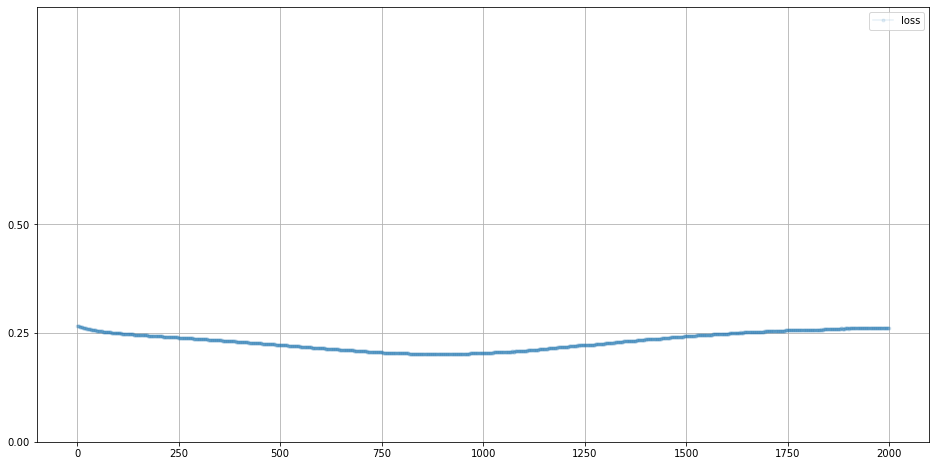

In [6]:
D.plot_progress()


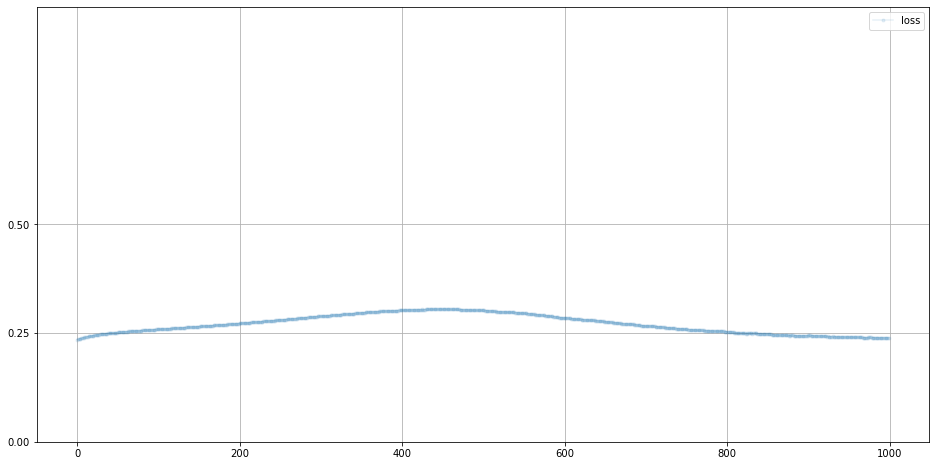

In [7]:
G.plot_progress()


In [8]:
G.forward(torch.FloatTensor([0.5]))


tensor([0.9211, 0.0656, 0.9124, 0.0549], grad_fn=<SigmoidBackward0>)

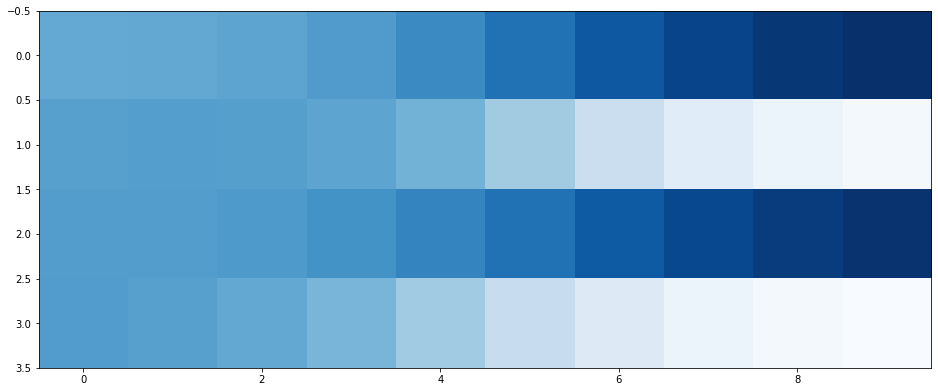

In [9]:
plt.figure(figsize=(16, 8))
plt.imshow(np.array(image_list).T, interpolation="none", cmap="Blues")
plt.show()